In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import joblib
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

from lightglue import LightGlue, ALIKED
from lightglue.utils import rbd

from datasets import Trainset, Testset, KeypointsDataset, collate_fn
from utils import average_euclidean_distance, visualize

from CrossAttentionCenterEstimator import CrossAttentionCenterEstimator 

D:\windows_envs\rgb_ir_mathing\Lib\site-packages\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Load thermal patches
with open("datasets/uav.pkl", "rb") as f:
    uav_data = joblib.load(f)
thermal_patches = uav_data['anchor']  
centers = uav_data['center']

Desc = """

We will be using ALIKED + LightGlue to generate matched keypoints. After keypoint generation,
we will be using the mached keypoints to estimate the center of RGB_Crop via another cross-attention transformer head.
"""

In [3]:
# set up seeds list to repeat experiments and other constants
seeds = [52,42,95, 123, 985] # items must be in between [0, 0xffff_ffff_ffff_ffff] range inclusive, otherwise torch raises error.
crop_size = 1536
patch_size = 512
num_visualizations = 4 # number of visiualizations per experiment. Must be smaller than num_samples.
num_samples = 5000 # how many samples to generate to train and test.

# CrossAttentionCenterEstimator Params:
num_epochs = 200  # Number of training epochs
embedding_dim = 128  # Arbitrary choice for embedding dimension
num_heads = 4  # Number of attention heads
num_layers = 2  # Number of transformer layers
max_num_matches = 50 # number of matches to consider when making predictions
batch_size = 32 # number of samples within a batch when training.

# select GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image to lightglue input casting with normalization.
img2torch = lambda x: torch.tensor(x, dtype=torch.float32).permute(2, 0, 1) / 255.0
target = np.array([-1,-1]).reshape(1,-1) # For punishing center estimation errors.

In [4]:
# ALIKED+LightGlue or SIFT+LightGlue,  Superpoint+LightGlue
extractor = ALIKED(max_num_keypoints = 4096).eval().to(device)
matcher = LightGlue(features='aliked',depth_confidence=-1, width_confidence=-1, ).eval().to(device)

In [5]:
# Set seeds (training only happens once.)
rng = np.random.default_rng(seeds[0])
_ = torch.manual_seed(seeds[0]) 

# Since lightglue inference accept batch size of 1, we will generate another dataset from matches for each sample in train and test dataset. 
trainset = Trainset(rgb_base_path="datasets/rgb_zone1.png", 
                    thermal_base_path="datasets/thermal_zone1.png", 
                    num_samples=num_samples, 
                    rng = rng, 
                    crop_size=crop_size, 
                    patch_size=patch_size)

trainset_samples_with_matches = []

with torch.no_grad(): # for some reason inference lightglue calculates gradients for match scores.
    for sample in tqdm(trainset):
        # get pair of images
        rgb_crop = img2torch(sample["rgb_crop"]).to(device)
        thermal_patch = img2torch(sample["thermal_patch"]).to(device)
        
        # lightglue inference only supports single batch operations
        # extract local features
        feats_rgb_crop = extractor.extract(rgb_crop)  # auto-resize the image, disable with resize=None
        feats_thermal_patch = extractor.extract(thermal_patch)
        
        # match the features
        matches_crop_patch = matcher({'image0': feats_rgb_crop, 'image1': feats_thermal_patch})
        feats_rgb_crop, feats_thermal_patch, matches_crop_patch = [rbd(x) for x in [feats_rgb_crop, feats_thermal_patch, matches_crop_patch]]  # remove batch dimension
        matches = matches_crop_patch['matches']  # indices with shape (K,2)
        points_rgb_crop = feats_rgb_crop['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
        points_thermal_patch = feats_thermal_patch['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)
    
        # delete image arrays since we have everything, we wont need them to train centerEstimator, and we have every information needed to recreate them when necessary
        del sample["rgb_crop"], sample["overlay"], sample["thermal_patch"]
            
        # add predicted keypoints as well as scores to the sample dict
        sample["points_rgb_crop"] = points_rgb_crop.cpu().numpy()
        sample["points_thermal_patch"] = points_thermal_patch.cpu().numpy()
        sample["points_matching_scores"] = matches_crop_patch["scores"].cpu().numpy()
        
        trainset_samples_with_matches.append(sample)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:00<00:00, 20.82it/s]


In [6]:
# Determine how many key points to feed to centerEstimator experimentally.
match_count_per_image = np.asarray([item["points_rgb_crop"].shape[0] for item in trainset_samples_with_matches])
print(f"Count of samples with at least some keypoint matches: {match_count_per_image[match_count_per_image>0].shape[0]}")
# 10 looks to be fine. But later I selected 50.
print(f"Count of samples without any keypoint matches: {match_count_per_image[match_count_per_image==0].shape[0]}")

Count of samples with at least some keypoint matches: 4881
Count of samples without any keypoint matches: 119


In [7]:
keypoints_trainset = KeypointsDataset(samples=trainset_samples_with_matches, max_num_matches=max_num_matches)
dataloader = DataLoader(keypoints_trainset, batch_size = batch_size, collate_fn=collate_fn, shuffle=True)

In [8]:
model = CrossAttentionCenterEstimator(embedding_dim, num_heads, num_layers).to(device)

In [9]:
# Loss function for regression (center prediction)
loss_fn = nn.MSELoss()
# Optimizer (Adam with learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Learning rate scheduler: Reduce the learning rate by a factor of 10 every 100 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [10]:
# Switch model to training mode
model.train()
loss_hist = []
for epoch in range(num_epochs):
    total_loss = 0
    for keypoints_rgb, keypoints_patch, mask, trainset_centers in dataloader:
        
        # Move data to the GPU if available
        keypoints_rgb, keypoints_patch, mask, trainset_centers = keypoints_rgb.to(device), keypoints_patch.to(device), mask.to(device) ,  trainset_centers.to(device)
        
        # A batch ended up without any matched sample, go to next iteration.
        if keypoints_rgb.size(0) == 0:
            continue 
            
        # Zero gradients before the forward pass
        optimizer.zero_grad()
        
        # Forward pass through the model
        predicted = model(keypoints_rgb, keypoints_patch, key_padding_mask=mask)

        # Compute the loss (MSE) (inputs, targets)
        loss = loss_fn(predicted, trainset_centers)
        
        # Backward pass (compute gradients)
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss for reporting
        total_loss += loss.item()

        # store batch loss for plotting
        loss_hist.append(loss.item())

    # Update the learning rate based on the scheduler
    scheduler.step()

    if (epoch + 1) % 20 == 0:
        # Print the loss after every 20 epochs
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Avg Loss: {avg_loss:.4f}, Last Batch loss: {loss.item():.4f}, Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

D:\win_codebase\cb_rgb_ir_matching\datasets.py:396: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  keypoints_a = torch.tensor(keypoints_a, dtype=torch.float32)


Epoch [20/200], Total Avg Loss: 0.0231, Last Batch loss: 0.0215, Learning rate: 0.001000
Epoch [40/200], Total Avg Loss: 0.0228, Last Batch loss: 0.0252, Learning rate: 0.001000
Epoch [60/200], Total Avg Loss: 0.0221, Last Batch loss: 0.0181, Learning rate: 0.001000
Epoch [80/200], Total Avg Loss: 0.0217, Last Batch loss: 0.0336, Learning rate: 0.001000
Epoch [100/200], Total Avg Loss: 0.0211, Last Batch loss: 0.0166, Learning rate: 0.000100
Epoch [120/200], Total Avg Loss: 0.0194, Last Batch loss: 0.0080, Learning rate: 0.000100
Epoch [140/200], Total Avg Loss: 0.0192, Last Batch loss: 0.0292, Learning rate: 0.000100
Epoch [160/200], Total Avg Loss: 0.0187, Last Batch loss: 0.0135, Learning rate: 0.000100
Epoch [180/200], Total Avg Loss: 0.0184, Last Batch loss: 0.0218, Learning rate: 0.000100
Epoch [200/200], Total Avg Loss: 0.0181, Last Batch loss: 0.0134, Learning rate: 0.000010



    Metrics for Experiment 1 (seed: 52) across it's Patches:
        
        Average testset error  (all predictions): 379.00 pixels
        
        Testset center point estimation fail count: 348 out of 5000 estimations
        
        Average testset error  (successful predictions): 350.85 pixels (4652/5000)
    
	Visualize Testset For Experiment 1:


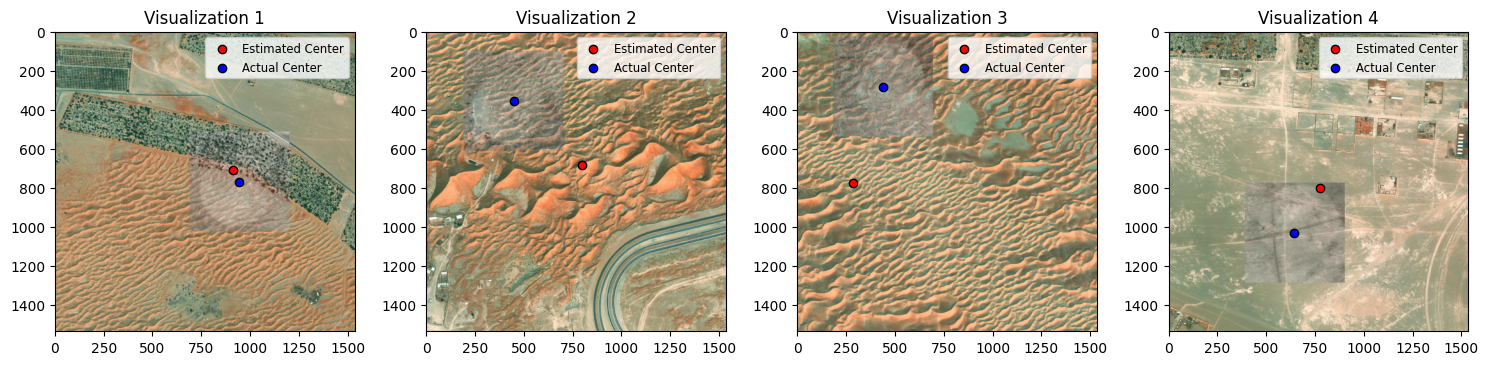

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


    Metrics for Experiment 2 (seed: 42) across it's Patches:
        
        Average testset error  (all predictions): 369.07 pixels
        
        Testset center point estimation fail count: 264 out of 5000 estimations
        
        Average testset error  (successful predictions): 348.77 pixels (4736/5000)
    
	Visualize Testset For Experiment 2:


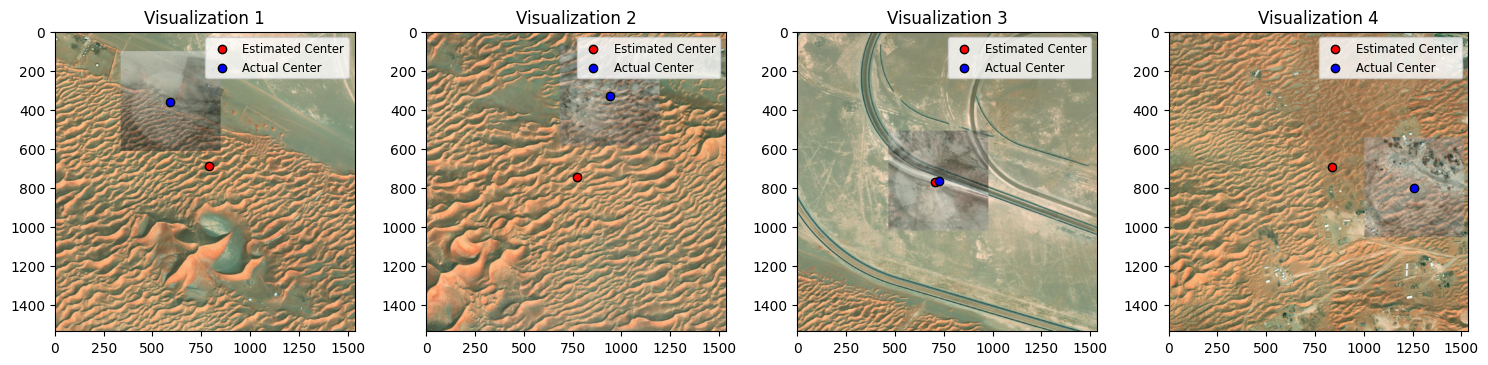

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


    Metrics for Experiment 3 (seed: 95) across it's Patches:
        
        Average testset error  (all predictions): 372.02 pixels
        
        Testset center point estimation fail count: 284 out of 5000 estimations
        
        Average testset error  (successful predictions): 348.79 pixels (4716/5000)
    
	Visualize Testset For Experiment 3:


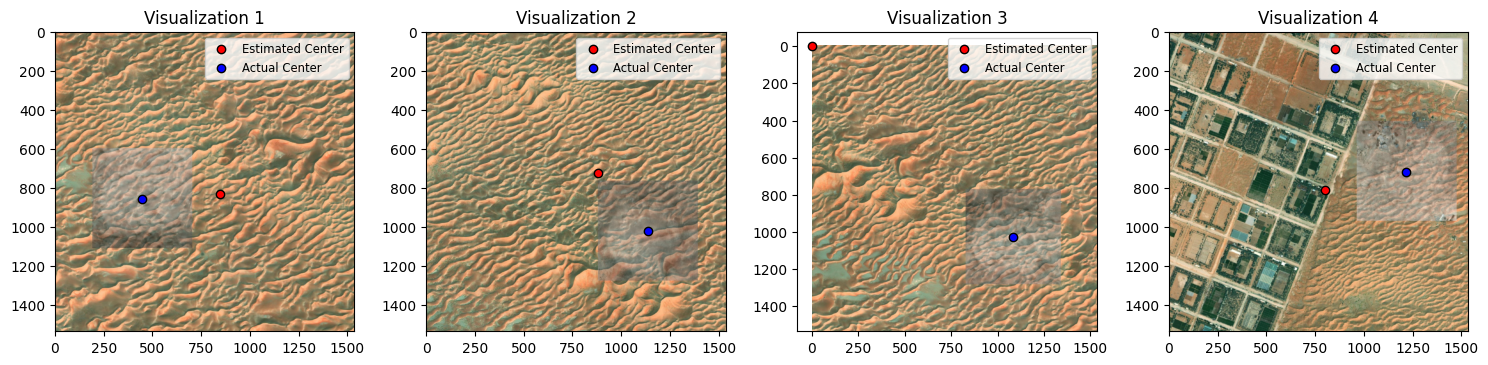

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


    Metrics for Experiment 4 (seed: 123) across it's Patches:
        
        Average testset error  (all predictions): 371.41 pixels
        
        Testset center point estimation fail count: 304 out of 5000 estimations
        
        Average testset error  (successful predictions): 346.70 pixels (4696/5000)
    
	Visualize Testset For Experiment 4:


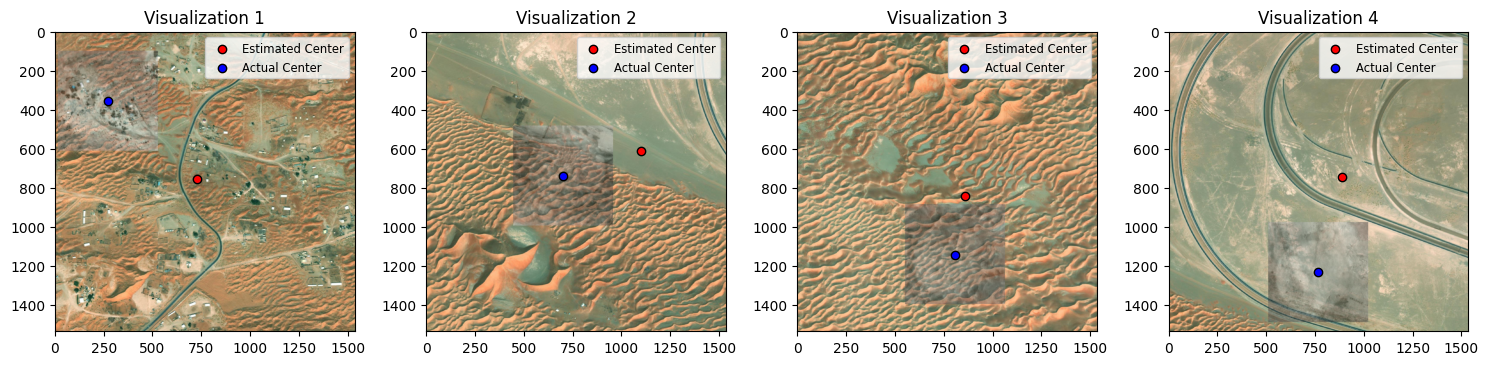

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


    Metrics for Experiment 5 (seed: 985) across it's Patches:
        
        Average testset error  (all predictions): 374.12 pixels
        
        Testset center point estimation fail count: 292 out of 5000 estimations
        
        Average testset error  (successful predictions): 351.99 pixels (4708/5000)
    
	Visualize Testset For Experiment 5:


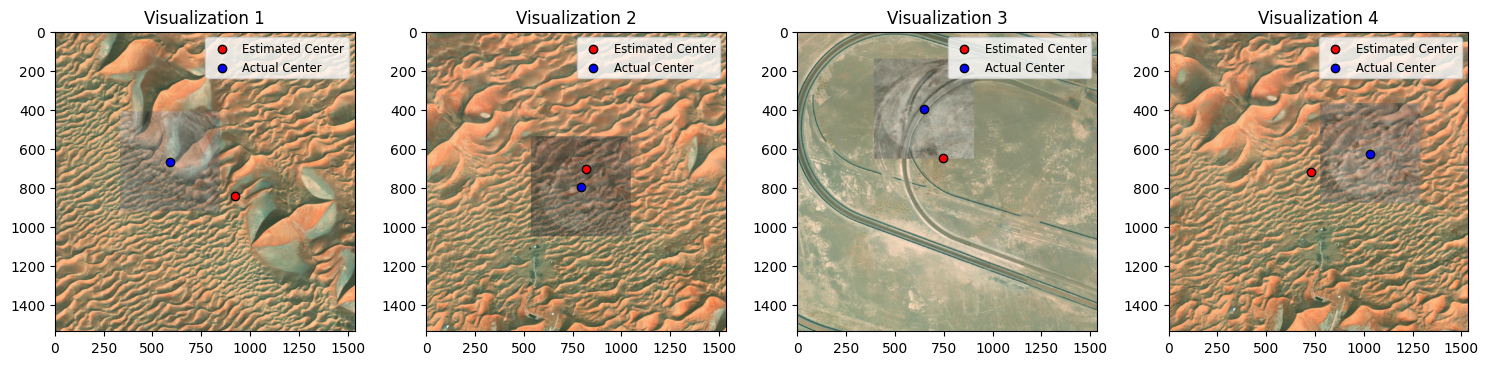

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [12]:
# Set the center estimator in eval mode.
model.eval()

# Initialize storage for across experiment statistics.
all_experiments_testset_estimated_centers = []
all_experiments_testset_ground_truth_centers = []

for experiment_num,seed in enumerate(seeds):
    # Initialize storage for per-experiment statistics
    testset_estimated_centers = []
    testset_ground_truth_centers = []

    #Set seeds per experiment.
    rng = np.random.default_rng(seed)
    _ = torch.manual_seed(seed) 
    
    testset = Testset(rgb_base_path="datasets/rgb_zone2.png", thermal_patches= thermal_patches, centers= centers, num_samples=num_samples, rng=rng, crop_size=crop_size, patch_size=patch_size)
    
    # Estimate centers and store it along with ground truth centers for trainset
    with torch.no_grad():
        for sample in testset:
            # get pair of images
            rgb_crop = img2torch(sample["rgb_crop"]).to(device)
            thermal_patch = img2torch(sample["thermal_patch"]).to(device)
            
            # lightglue inference only supports single batch operations
            # extract local features
            feats_rgb_crop = extractor.extract(rgb_crop)  # auto-resize the image, disable with resize=None
            feats_thermal_patch = extractor.extract(thermal_patch)
            
            # match the features
            matches_crop_patch = matcher({'image0': feats_rgb_crop, 'image1': feats_thermal_patch})
            feats_rgb_crop, feats_thermal_patch, matches_crop_patch = [rbd(x) for x in [feats_rgb_crop, feats_thermal_patch, matches_crop_patch]]  # remove batch dimension
            matches = matches_crop_patch['matches']  # indices with shape (K,2)
            points_rgb_crop = feats_rgb_crop['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points_thermal_patch = feats_thermal_patch['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)
        
            sample["points_rgb_crop"] = points_rgb_crop.cpu().numpy()
            sample["points_thermal_patch"] = points_thermal_patch.cpu().numpy()
            sample["points_matching_scores"] = matches_crop_patch["scores"].cpu().numpy()
        
            # Use trained model to predict center if there are matches, otherwise punish.
            if points_rgb_crop.nelement() > 0:
                # pad, mask and normalize keypoints.
                keypoints_rgb, keypoints_patch, mask, testset_centers = next(iter(DataLoader(KeypointsDataset(samples=[sample], max_num_matches=50),
                                                shuffle=False, 
                                                batch_size=1, 
                                                collate_fn = collate_fn)))
                
                # Estimate the center using CrossAttentionCenterEstimator, denormalize, and finally typecast.
                estimated_center = np.round(model(keypoints_rgb.to(device), 
                                                  keypoints_patch.to(device), 
                                                  key_padding_mask=mask.to(device)).cpu().numpy() * crop_size).astype(int)
                testset_estimated_centers.append(estimated_center)
                all_experiments_testset_estimated_centers.append(estimated_center)
            else:
                testset_estimated_centers.append(target) # Could not make a center prediction, punish. (-1,-1) so that we could count it later.
                all_experiments_testset_estimated_centers.append(target)
                
            # add ground truth to statistics.
            testset_ground_truth_centers.append(sample["patch_center_crop"])
            all_experiments_testset_ground_truth_centers.append(sample["patch_center_crop"])

    # Calculate average prediction error for the experiment.
    testset_avg_euclidian_distance_error = average_euclidean_distance(np.asarray(testset_estimated_centers).reshape(-1,2),testset_ground_truth_centers)
    
    # Get prediction fail count for the experiment.
    testset_fail_count = np.sum(np.all(np.stack(testset_estimated_centers) == target,axis=1))
    
    # Get sample predictions that could be made for the experiment
    testset_indices = np.where(~np.all(np.stack(testset_estimated_centers) == target, axis=1))[0]

    # Calculate succesfull prediction statistics for the experiment
    testset_avg_succ_euclidian_distance_error =  average_euclidean_distance(np.asarray(testset_estimated_centers).reshape(-1,2)[testset_indices,:],
                                                                            np.asarray(testset_ground_truth_centers)[testset_indices,:])
    
    print(f"""
    Metrics for Experiment {experiment_num + 1} (seed: {seed}) across it's Patches:
        
        Average testset error  (all predictions): {testset_avg_euclidian_distance_error:.2f} pixels
        
        Testset center point estimation fail count: {testset_fail_count} out of {len(testset_estimated_centers)} estimations
        
        Average testset error  (successful predictions): {testset_avg_succ_euclidian_distance_error:.2f} pixels ({len(testset_estimated_centers)-testset_fail_count}/{len(testset_estimated_centers)})
    """)
    
    print(f"\tVisualize Testset For Experiment {experiment_num + 1}:")
    visualize(testset[-num_visualizations:],
              estimated_centers=np.asarray(testset_estimated_centers[-num_visualizations:]).reshape(-1,2))

    print(f"\t{'-'*220}","\n")
    


Metrics for All experiements Across All Patches:
    
    Average testset error  (all predictions): 373.12 pixels
    
    Testset center point estimation fail count: 1492 out of 25000 estimations
    
    Average testset error  (successful predictions): 349.42 pixels (23508/25000)

	Visualize Testset: 


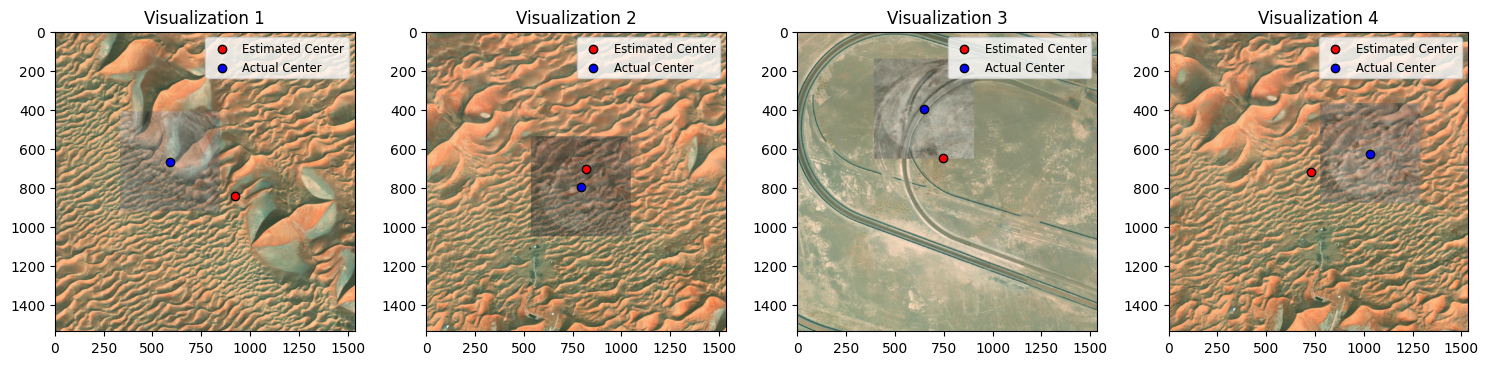

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [13]:
# Calculate average prediction error across all experiments.
all_experiments_testset_avg_euclidian_distance_error = average_euclidean_distance(np.asarray(all_experiments_testset_estimated_centers).reshape(-1,2),all_experiments_testset_ground_truth_centers)

# Get prediction fail count across all experiments
testset_fail_count = np.sum(np.all(np.stack(all_experiments_testset_estimated_centers) == target,axis=1))

# Get samples predictions that could be made across experiments
testset_indices = np.where(~np.all(np.stack(all_experiments_testset_estimated_centers) == target, axis=1))[0]

# Calculate average prediction error across all experiments where predictions did not fail.
all_experiments_testset_avg_succ_euclidian_distance_error =  average_euclidean_distance(np.asarray(all_experiments_testset_estimated_centers).reshape(-1,2)[testset_indices,:],
                                                                        np.asarray(all_experiments_testset_ground_truth_centers)[testset_indices,:])

print(f"""
Metrics for All experiements Across All Patches:
    
    Average testset error  (all predictions): {all_experiments_testset_avg_euclidian_distance_error:.2f} pixels
    
    Testset center point estimation fail count: {testset_fail_count} out of {len(all_experiments_testset_ground_truth_centers)} estimations
    
    Average testset error  (successful predictions): {all_experiments_testset_avg_succ_euclidian_distance_error:.2f} pixels ({len(all_experiments_testset_ground_truth_centers)-testset_fail_count}/{len(all_experiments_testset_ground_truth_centers)})
""")

print("\tVisualize Testset: ")
visualize(testset[-num_visualizations:],
          estimated_centers=np.asarray(testset_estimated_centers[-num_visualizations:]).reshape(-1,2))
print(f"\t{'-'*220}","\n")
    